In [1]:
# !pip install pandas
import os
import numpy as np 
import pandas as pd 
import json
# ====================================================
# Library
# ====================================================

import sys

import gc
import os
import random
import time
from contextlib import contextmanager
from pathlib import Path

import cv2
from PIL import Image
import numpy as np
import pandas as pd
import scipy as sp

import sklearn.metrics

from functools import partial

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset

from albumentations import Compose, Normalize, Resize
from albumentations.pytorch import ToTensorV2

import torch
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# !pip install tqdm
from tqdm import tqdm

In [2]:
# !pip install sklearn
# from sklearn import preprocessing

# le = preprocessing.LabelEncoder()
# le.fit(train_df['category_id'])
# train_df['category_id_le'] = le.transform(train_df['category_id'])
# class_map = dict(sorted(train_df[['category_id_le', 'category_id']].values.tolist()))


In [3]:
base_path = "D:\\data\\cvpr_birds\\annotation\\annotation"
annots = { 
    "train": "anno_l_train.json",
    "validation": "anno_val.json",
    "test": "anno_test.json"
               }

In [4]:
# load train annotation file
with open(base_path+"\\"+annots["train"], "r", encoding="ISO-8859-1") as file:
    train_annotations = json.load(file)
# get image details 
train_imgs = pd.DataFrame(train_annotations['images'])
# get image cateogry and other relevant details
train_anns = pd.DataFrame(train_annotations['annotations']).drop(columns='image_id')
# merge file detail and its category
train_df = train_imgs.merge(train_anns, on='id')    
train_df
# list(train_df['file_name'].values)
list(train_df[train_df.category_id==0]['file_name'].values)

['trainval_images/0/0.jpg',
 'trainval_images/0/1.jpg',
 'trainval_images/0/2.jpg',
 'trainval_images/0/3.jpg',
 'trainval_images/0/4.jpg',
 'trainval_images/0/5.jpg',
 'trainval_images/0/6.jpg',
 'trainval_images/0/7.jpg',
 'trainval_images/0/8.jpg',
 'trainval_images/0/9.jpg',
 'trainval_images/0/10.jpg',
 'trainval_images/0/11.jpg',
 'trainval_images/0/12.jpg',
 'trainval_images/0/13.jpg',
 'trainval_images/0/14.jpg',
 'trainval_images/0/15.jpg',
 'trainval_images/0/16.jpg',
 'trainval_images/0/17.jpg',
 'trainval_images/0/18.jpg',
 'trainval_images/0/19.jpg',
 'trainval_images/0/20.jpg',
 'trainval_images/0/21.jpg',
 'trainval_images/0/22.jpg',
 'trainval_images/0/23.jpg',
 'trainval_images/0/24.jpg',
 'trainval_images/0/25.jpg',
 'trainval_images/0/26.jpg',
 'trainval_images/0/27.jpg',
 'trainval_images/0/28.jpg',
 'trainval_images/0/29.jpg']

In [5]:
# load train annotation file
with open(base_path+"\\"+annots["validation"], "r", encoding="ISO-8859-1") as file:
    val_annotations = json.load(file)
# get image details 
val_imgs = pd.DataFrame(val_annotations['images'])
# get image cateogry and other relevant details
val_anns = pd.DataFrame(val_annotations['annotations']).drop(columns='image_id')
# merge file detail and its category
val_df = val_imgs.merge(val_anns, on='id')    
val_df 

,file_name,width,height,id,category_id
0,trainval_images/0/30.jpg,500,278,0,0
1,trainval_images/0/31.jpg,500,333,1,0
2,trainval_images/0/32.jpg,375,500,2,0
3,trainval_images/0/33.jpg,500,375,3,0
4,trainval_images/0/34.jpg,500,375,4,0
...,...,...,...,...,...
1995,trainval_images/199/11.jpg,500,375,1995,199
1996,trainval_images/199/12.jpg,500,333,1996,199
1997,trainval_images/199/13.jpg,500,333,1997,199
1998,trainval_images/199/14.jpg,500,333,1998,199


In [6]:
frames = [train_df, val_df]

trainval_df = pd.concat(frames)
trainval_df

,file_name,width,height,id,category_id
0,trainval_images/0/0.jpg,500,388,0,0
1,trainval_images/0/1.jpg,500,375,1,0
2,trainval_images/0/2.jpg,500,375,2,0
3,trainval_images/0/3.jpg,500,331,3,0
4,trainval_images/0/4.jpg,500,387,4,0
...,...,...,...,...,...
1995,trainval_images/199/11.jpg,500,375,1995,199
1996,trainval_images/199/12.jpg,500,333,1996,199
1997,trainval_images/199/13.jpg,500,333,1997,199
1998,trainval_images/199/14.jpg,500,333,1998,199


In [7]:
with open(base_path+"\\"+annots["test"], "r", encoding="ISO-8859-1") as file:
    test = json.load(file)

test_df = pd.DataFrame(test['images'])
test_df.head()

,file_name,width,height,id
0,test/0.jpg,500,375,0
1,test/1.jpg,500,375,1
2,test/2.jpg,500,474,2
3,test/3.jpg,500,375,3
4,test/4.jpg,500,295,4


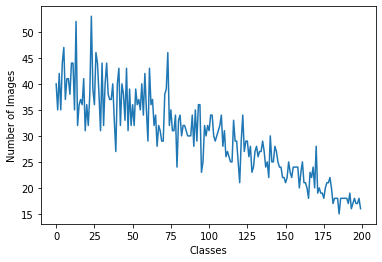

In [11]:
def get_class_num():
    a = trainval_df['category_id'].value_counts().to_dict()
    # a = val_df['category_id'].value_counts().to_dict()

    cat = []
    nums= []
    for i in range(200):
        nums.append(a[i])
        cat.append(i)
        #nums.append(j)
    return nums    
from matplotlib import pyplot as plt    
plt.plot(nums)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.savefig("imgs/class_dist.png")

In [14]:
def get_class_weights(beta):
    samples_per_cls = get_class_num()
    cls_num_list = samples_per_cls/np.sum(samples_per_cls)
    effective_num = 1.0 - np.power(beta, cls_num_list)
    per_cls_weights = (1.0 - beta) / np.array(effective_num)
    per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(cls_num_list)
    per_cls_weights = torch.FloatTensor(per_cls_weights)
    return cls_num_list, per_cls_weights
get_class_weights(0.999)

(array([0.00671254, 0.00587347, 0.00704816, 0.00587347, 0.00738379,
        0.00788723, 0.0062091 , 0.00688035, 0.00688035, 0.00637691,
        0.00738379, 0.00738379, 0.00587347, 0.0087263 , 0.00537003,
        0.00604128, 0.0062091 , 0.00604128, 0.00688035, 0.00520222,
        0.00604128, 0.00537003, 0.00637691, 0.00889411, 0.00654472,
        0.00604128, 0.00771942, 0.00738379, 0.00637691, 0.00520222,
        0.00738379, 0.00537003, 0.00671254, 0.00738379, 0.00637691,
        0.0062091 , 0.0062091 , 0.00671254, 0.00553784, 0.00453096,
        0.00671254, 0.00721598, 0.00537003, 0.00671254, 0.00637691,
        0.00553784, 0.00721598, 0.00520222, 0.00654472, 0.00537003,
        0.00604128, 0.00537003, 0.00654472, 0.00604128, 0.0062091 ,
        0.00587347, 0.00671254, 0.00570566, 0.00704816, 0.00587347,
        0.00486659, 0.00721598, 0.00604128, 0.0062091 , 0.00537003,
        0.00570566, 0.00469877, 0.00537003, 0.00520222, 0.00486659,
        0.00486659, 0.00637691, 0.00654472, 0.00

In [8]:
N_CLASSES = 200

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['file_name'].values[idx]
        data_path = "D:\\data\\test\\"
        file_path = data_path+"\\"+file_name
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image
    

class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.labels = df["category_id"]
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['file_name'].values[idx]
        data_path = "D:\data\\trainval_images"
        file_path = os.path.join(data_path, file_name)
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels.values[idx]
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, label  

In [9]:
HEIGHT = 128
WIDTH = 128


def get_transforms( data):
    
    assert data in ('train', 'valid', 'test')
    
    if data == 'train':
        return Compose([
            Resize(HEIGHT, WIDTH),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return Compose([
            Resize(HEIGHT, WIDTH),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    elif data == 'test':
        return Compose([
            Resize(HEIGHT, WIDTH),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
  

In [16]:
batch_size = 64

test_dataset = TestDataset(test_df, transform=get_transforms(data='test'))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

valid_dataset = TrainDataset(valid_df, transform=get_transforms(data='valid'))
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

train_dataset = TrainDataset(train_df, transform=get_transforms('train'))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [17]:
import torchvision.models as models

model = models.resnet18(pretrained=True)
model.avgpool = nn.AdaptiveAvgPool2d(1)
model.fc = nn.Linear(model.fc.in_features, N_CLASSES)


In [12]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import tqdm 
n_epochs = 1
lr = 4e-4

model.to(device)

optimizer = Adam(model.parameters(), lr=lr, amsgrad=False)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.75, patience=5, verbose=True, eps=1e-6)

criterion = nn.CrossEntropyLoss()
best_score = 0.
best_loss = np.inf

for epoch in range(n_epochs):

    start_time = time.time()

    model.train()
    avg_loss = 0.

    optimizer.zero_grad()

    for i, (images, labels) in (enumerate(train_loader)):

        images = images.to(device)
        labels = labels.to(device)

        y_preds = model(images)
        loss = criterion(y_preds, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        avg_loss += loss.item() / len(train_loader)

    model.eval()
    avg_val_loss = 0.
    preds = np.zeros((len(valid_loader)))

    for i, (images, labels) in enumerate(valid_loader):

        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            y_preds = model(images)

        preds[i * batch_size: (i+1) * batch_size] = y_preds.argmax(1).to('cpu').numpy()

        loss = criterion(y_preds, labels)
        avg_val_loss += loss.item() / len(valid_loader)

    scheduler.step(avg_val_loss)

    score = f1_score(folds.loc[val_idx]['category_id'].values, preds, average='macro')

    elapsed = time.time() - start_time

    LOGGER.debug(f'  Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  F1: {score:.6f}  time: {elapsed:.0f}s')

    if score>best_score:
        best_score = score
        LOGGER.debug(f'  Epoch {epoch+1} - Save Best Score: {best_score:.6f} Model')
        torch.save(model.state_dict(), f'fold{FOLD}_best_score.pth')

    if avg_val_loss<best_loss:
        best_loss = avg_val_loss
        LOGGER.debug(f'  Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        torch.save(model.state_dict(), f'fold{FOLD}_best_loss.pth')

KeyboardInterrupt: 

In [18]:


    
model.to(device) 
test_loader = valid_loader
preds = np.zeros((len(test_dataset), 200))

for i, (images, label) in (enumerate(test_loader)):

    images = images.to(device)

    with torch.no_grad():
        y_preds = model(images)
        print(y_preds.shape)

    preds[i * batch_size: (i+1) * batch_size] = y_preds.to('cpu').numpy()
    break

torch.Size([64, 200])


In [53]:
a = np.argsort(preds, axis=1)[:,::-1]
print(a.shape)
print(a[:,0:5])
# print(np.argsort(preds,axis=1)[:,-5:])

(8000, 200)
[[ 46 109  33 189 129]
 [189 174  72 151 108]
 [ 37 168 108 120  16]
 ...
 [199  62  72  71  70]
 [199  62  72  71  70]
 [199  62  72  71  70]]


## Submission 

In [54]:
def make_final_submission(preds, submission_file_name):
    final_pred1 = np.argsort(preds, axis=1)[:,::-1]
    final_pred = final_pred1[:,0:5]
    sub = []
    for num, item in enumerate(final_pred):
        lbs = ""
        for i in item:
            lbs+=" "+str(i)
        sub.append([num, lbs])

    pd_sub = pd.DataFrame(sub, columns=["Id","Category"])
    pd_sub.to_csv("random_sub.csv", index=False)    